In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from scipy import stats

# 노트북 안에 그래프를 그리기 위해
%matplotlib inline

# 그래프를 그리기 위한 기본 설정
# 폰트설정 - 윈도우
plt.rcParams['font.family'] = 'Malgun Gothic'

# 폰트설정 - 맥
# plt.rcParams['font.family'] = 'Apple Gothic'

# 그래프의 크기
plt.rcParams['figure.figsize'] = 12, 6

# 글자 크기
plt.rcParams['font.size'] = 14

# 그래프에서 격자로 숫자 범위가 눈에 잘 띄도록 ggplot 스타일을 사용
plt.style.use('ggplot')

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

In [27]:
# 데이터 불러오기
data = pd.read_excel('socar_train.xlsx')

data.shape

(9741, 12)

In [29]:
data.head()

,ATA,id,api_eta,created_at_kst,month,pickup_lng,pickup_lat,pickup_gu,driver_id,driver_lng,driver_lat,hour
0,10.60,R4L9FL6NVEL4D0,5.65,2019-12-01T00:55:09,12,127.091399,37.624545,노원구,DST52944,127.069978,37.616472,0
1,9.20,R3A7JBY7CS6TPD,8.60,2019-12-01T00:09:39,12,127.023351,37.625564,강북구,DPC72995,127.026479,37.604711,0
2,10.85,R2BIUY1TDK14XE,10.53,2019-12-15T00:18:42,12,126.881154,37.481641,금천구,DPP94923,126.906225,37.452167,0
3,5.52,R31PU5GNHSGU6C,1.92,2019-07-31T00:24:11,7,126.988375,37.567897,중구,DCT73585,126.991170,37.566416,0
4,8.60,R41WR6N1VT42DJ,7.10,2019-07-05T00:40:34,7,126.988684,37.566716,중구,DPJ86237,127.006860,37.571164,0


ATA: 도착예정시간
api_eta: 네이버 API를 활용한 예상도착시간

In [30]:
# 한번 확인해주고
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9741 entries, 0 to 9740
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ATA             9741 non-null   float64
 1   id              9741 non-null   object 
 2   api_eta         9741 non-null   float64
 3   created_at_kst  9741 non-null   object 
 4   month           9741 non-null   int64  
 5   pickup_lng      9741 non-null   float64
 6   pickup_lat      9741 non-null   float64
 7   pickup_gu       9741 non-null   object 
 8   driver_id       9741 non-null   object 
 9   driver_lng      9741 non-null   float64
 10  driver_lat      9741 non-null   float64
 11  hour            9741 non-null   int64  
dtypes: float64(6), int64(2), object(4)
memory usage: 913.3+ KB


### 결측치 확인

In [31]:
data.isnull().sum()

ATA               0
id                0
api_eta           0
created_at_kst    0
month             0
pickup_lng        0
pickup_lat        0
pickup_gu         0
driver_id         0
driver_lng        0
driver_lat        0
hour              0
dtype: int64

## 데이터 전처리
- 시계열 전처리
- 도착 시간 오차(arrived_error)
- 거리 차이(이건 내일 물어보자ㅜㅜ)

In [32]:
# 시계열 전처리
time_split = data['created_at_kst'].str.split('T')
date_time = time_split.str.join(' ')
data['created_at_kst'] = pd.to_datetime(date_time)

In [33]:
# 시각화해서 보기 편하게 연, 월, 일, 시간, 분, 초로 나누어 train 데이터에 추가
data['year'] = data['created_at_kst'].dt.year
data['month'] = data['created_at_kst'].dt.month
data['day'] = data['created_at_kst'].dt.day
data['hour'] = data['created_at_kst'].dt.hour
data['minute'] = data['created_at_kst'].dt.minute
data['second'] = data['created_at_kst'].dt.second
data.shape

(9741, 16)

In [34]:
data.head(10)

,ATA,id,api_eta,created_at_kst,month,pickup_lng,pickup_lat,pickup_gu,driver_id,driver_lng,driver_lat,hour,year,day,minute,second
0,10.60,R4L9FL6NVEL4D0,5.65,2019-12-01 00:55:09,12,127.091399,37.624545,노원구,DST52944,127.069978,37.616472,0,2019,1,55,9
1,9.20,R3A7JBY7CS6TPD,8.60,2019-12-01 00:09:39,12,127.023351,37.625564,강북구,DPC72995,127.026479,37.604711,0,2019,1,9,39
2,10.85,R2BIUY1TDK14XE,10.53,2019-12-15 00:18:42,12,126.881154,37.481641,금천구,DPP94923,126.906225,37.452167,0,2019,15,18,42
3,5.52,R31PU5GNHSGU6C,1.92,2019-07-31 00:24:11,7,126.988375,37.567897,중구,DCT73585,126.991170,37.566416,0,2019,31,24,11
4,8.60,R41WR6N1VT42DJ,7.10,2019-07-05 00:40:34,7,126.988684,37.566716,중구,DPJ86237,127.006860,37.571164,0,2019,5,40,34
5,7.37,R32IGPT5C9Y45Z,0.97,2019-12-25 00:42:12,12,126.977273,37.569075,중구,DPC23623,126.977267,37.567136,0,2019,25,42,12
6,7.52,R387PWH9XAVRTV,8.20,2019-12-07 00:39:11,12,126.972539,37.564717,중구,DMS04663,126.959003,37.568392,0,2019,7,39,11
7,14.25,R3UJ7NHLB06UOJ,9.50,2019-07-05 00:21:31,7,126.973817,37.553968,중구,DMS90060,126.953749,37.542670,0,2019,5,21,31
8,15.62,R2UBSRGCZCURD7,8.65,2019-07-06 00:50:49,7,126.992479,37.568064,중구,DCT74872,126.996441,37.579948,0,2019,6,50,49
9,3.93,R2TW90T09OX19S,4.48,2019-12-12 00:53:24,12,126.966175,37.558524,중구,DBL57567,126.954087,37.547253,0,2019,12,53,24


In [35]:
# 도착 시간 오차
data['arrived_error'] = data['ATA'] - data['api_eta']

data.head()

,ATA,id,api_eta,created_at_kst,month,pickup_lng,pickup_lat,pickup_gu,driver_id,driver_lng,driver_lat,hour,year,day,minute,second,arrived_error
0,10.60,R4L9FL6NVEL4D0,5.65,2019-12-01 00:55:09,12,127.091399,37.624545,노원구,DST52944,127.069978,37.616472,0,2019,1,55,9,4.95
1,9.20,R3A7JBY7CS6TPD,8.60,2019-12-01 00:09:39,12,127.023351,37.625564,강북구,DPC72995,127.026479,37.604711,0,2019,1,9,39,0.60
2,10.85,R2BIUY1TDK14XE,10.53,2019-12-15 00:18:42,12,126.881154,37.481641,금천구,DPP94923,126.906225,37.452167,0,2019,15,18,42,0.32
3,5.52,R31PU5GNHSGU6C,1.92,2019-07-31 00:24:11,7,126.988375,37.567897,중구,DCT73585,126.991170,37.566416,0,2019,31,24,11,3.60
4,8.60,R41WR6N1VT42DJ,7.10,2019-07-05 00:40:34,7,126.988684,37.566716,중구,DPJ86237,127.006860,37.571164,0,2019,5,40,34,1.50


In [36]:
# id라는 건 고유한 데이터군
data['id'].value_counts()

R2DGN0ES7FJBYQ    1
R20S7C29M1WVB7    1
R2C1JMLP1YS4TO    1
RYW2VQS0AKMQW     1
R33EU3IQLJ9RUA    1
                 ..
R3IQ0ESOANUASJ    1
R29H5FUZY2ZJJR    1
R3L8ECZURBZB18    1
R4E6ZZVFMX0F90    1
RE67FVU4OLXKW     1
Name: id, Length: 9741, dtype: int64

In [37]:
data.shape

(9741, 17)

In [38]:
# driver_id는 고유하지 않고, 여러 번 운전하신 기사님이 있다. 기사님의 성격을 유추할 수 있을까?
data['driver_id'].value_counts()

DHP35897    15
DJN80873    14
DRD89607    13
DHP29966    13
DST66086    13
            ..
DRD24140     1
DPC16165     1
DTS37505     1
DMJ13452     1
DUL44455     1
Name: driver_id, Length: 3708, dtype: int64

[Text(0.5, 0, 'hour'), Text(0.5, 1.0, '시간별 시간 오차')]

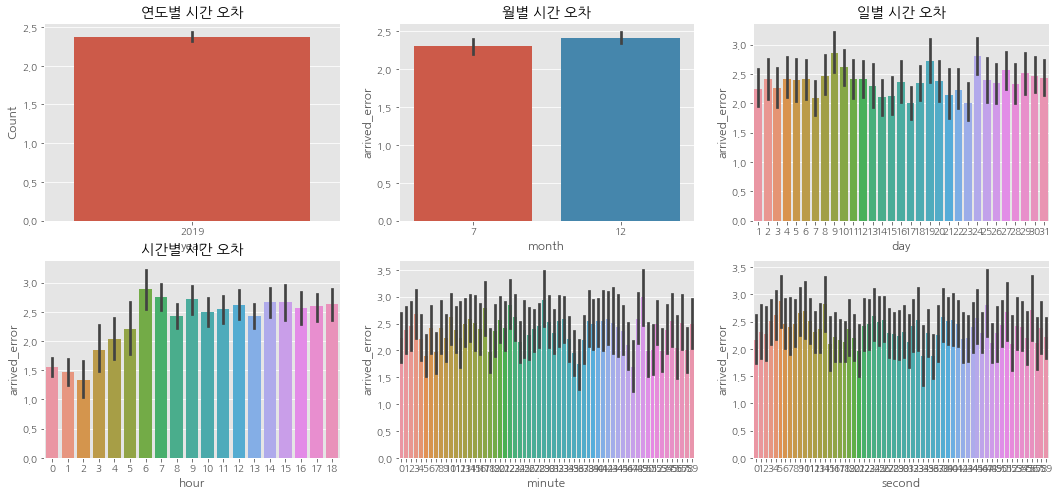

In [39]:
# 각 시계열과 arrived_error와의 관계 보기
figure, ((ax1,ax2,ax3), (ax4,ax5,ax6)) = plt.subplots(nrows=2, ncols=3)
figure.set_size_inches(18,8)

sns.barplot(data=data, x="year", y="arrived_error", ax=ax1)
sns.barplot(data=data, x="month", y="arrived_error", ax=ax2)
sns.barplot(data=data, x="day", y="arrived_error", ax=ax3)
sns.barplot(data=data, x="hour", y="arrived_error", ax=ax4)
sns.barplot(data=data, x="minute", y="arrived_error",ax=ax5)
sns.barplot(data=data, x="second", y="arrived_error", ax=ax6)

ax1.set(ylabel='Count', title="연도별 시간 오차")
ax2.set(xlabel='month', title="월별 시간 오차")
ax3.set(xlabel='day', title="일별 시간 오차")
ax4.set(xlabel='hour', title="시간별 시간 오차")

### 알 수 있는 사실
1. 월별 시간오차는 7월보다 12월이 더 컸다.
2. 시간별 그래프를 확인해봤을 때, 사람들이 일과를 보내는 시간대에 더 큰 시간오차를 보였다. 

### 인사이트
1. 7월과 12월을 서로 다른 계절, 날씨를 갖고 있다. 그 때의 환경에 드라이버에게 무슨 변화가 있을까?
2. 일과시간과 시간오차와의 관계는 교통과 관련이 있을 것 같지만 현재 데이터에는 교통관련정보가 없다. 

### 드라이버에 따른 시간오차

In [40]:
# 드라이버 id와 도착시간오차를 가져온다.
data['arrived_error']
df_driver_ae = data[['driver_id', 'arrived_error']]
df_driver_ae

,driver_id,arrived_error
0,DST52944,4.95
1,DPC72995,0.60
2,DPP94923,0.32
3,DCT73585,3.60
4,DPJ86237,1.50
...,...,...
9736,DJL79312,3.19
9737,DJL96447,9.50
9738,DRD55676,1.20
9739,DPC19392,7.85


In [107]:
# 드라이버별 시간오차 평균을 구한다.
df_result = df_driver_ae.groupby('driver_id').mean()
df_result.columns = ['avg_error']
df_result

,avg_error
driver_id,
DBL00672,1.896667
DBL01022,1.700000
DBL01157,5.820000
DBL02265,2.655000
DBL02787,3.000000
...,...
DWZ96948,4.400000
DWZ97755,3.752000
DWZ97808,7.280000


In [90]:
df_result.sort_values('avg_error', ascending=False, inplace=True)
display(df_result.head(10))
# df_result.columns = ['driver_id' , 'arrived_error']
# sns.barplot(x='driver_id', y ='arrived_error', data=df_result)
display(df_result.shape)

,avg_error
driver_id,
DPC00638,23.37
DTH17690,21.33
DHP40769,18.41
DRD30555,17.94
DRD56523,16.47
DJN31071,16.15
DPJ91014,15.63
DHR87926,15.50
DHR83024,15.37


(3708, 1)

In [111]:
too_late=df_result[df_result['avg_error'] >= 10]
display(too_late.shape)
too_late_list = list(too_late.index)
too_late_driver = data[data['driver_id'].isin(too_late_list)]

too_late_lank = pd.DataFrame(too_late_driver['driver_id'].value_counts())
too_late_lank.columns = ['driving_cnt']
too_late_lank.sort_values('driving_cnt', ascending=False, inplace=True)
too_late_lank['avg_error'] = df_driver_ae.groupby('driver_id').mean()
too_late_lank['sum_error'] = df_driver_ae.groupby('driver_id').sum()
too_late_lank

(36, 1)

,driving_cnt,avg_error,sum_error
DPJ46800,3,10.720000,32.16
DHP61149,3,10.196667,30.59
DRD26162,2,12.050000,24.10
DJN35033,2,13.150000,26.30
DTH89070,2,10.840000,21.68
DPT59945,2,13.905000,27.81
DMJ31474,2,11.110000,22.22
DTN55297,2,10.655000,21.31
DPJ21919,2,10.110000,20.22
DJN43971,1,15.240000,15.24


### 알 수 있는 사실
- 평균으로 시간 오차가 높은 드라이버를 뽑았더니, 운전 횟수가 1~3번이었다.
- 평균 시간 오차가 10인 드라이버가 3번을 운전했다해도 총 시간 오차는 30밖에 안된다.


<br>

### 느낀점
- 운전횟수가 많을수록 분모가 커지면서 오히려 평균이 낮은 수치들 중에 다수의 운전을 한 드라이버가 있을 수 있다.
- `sum`으로 통계를 내어 상습범을 잡아보자.

In [112]:
df_result = df_driver_ae.groupby('driver_id').sum()
df_result.sort_values('arrived_error', ascending = False, inplace=True)
df_result.columns = ['sum_error']
df_result

,sum_error
driver_id,
DJL92641,53.91
DMG06920,51.43
DRD54135,47.40
DHR58606,47.12
DMG37159,41.90
...,...
DPK93313,-6.06
DMS54691,-6.42
DHR79832,-6.60


In [68]:
# 시간오차 합계가 가장 큰 사람을 조사한 결과
data[data['driver_id'] == 'DJL92641']

,ATA,id,api_eta,created_at_kst,month,pickup_lng,pickup_lat,pickup_gu,driver_id,driver_lng,driver_lat,hour,year,day,minute,second,arrived_error
382,9.73,R3KCOUB34CSK26,3.57,2019-12-14 00:10:53,12,126.923058,37.556148,마포구,DJL92641,126.919280,37.551963,0,2019,14,10,53,6.16
675,3.70,RHQJB4244GMHA,4.63,2019-12-14 00:38:41,12,126.967452,37.529884,용산구,DJL92641,126.966481,37.534374,0,2019,14,38,41,-0.93
1508,16.05,R42OHL0XL5UPIC,7.70,2019-12-07 02:42:57,12,127.127528,37.537593,강동구,DJL92641,127.100808,37.512605,2,2019,7,42,57,8.35
7833,2.70,R4OECKJ4ZGFYOX,1.92,2019-12-16 16:56:54,12,126.973243,37.555499,중구,DJL92641,126.972346,37.551047,16,2019,16,56,54,0.78
9479,21.90,R2NTYFZN8MCDLL,12.53,2019-07-29 18:02:24,7,126.930666,37.496510,동작구,DJL92641,126.924464,37.485052,18,2019,29,2,24,9.37
9560,31.45,R2C8VKY00VXZYL,10.00,2019-12-12 18:02:52,12,127.015148,37.504345,서초구,DJL92641,126.999641,37.497503,18,2019,12,2,52,21.45
9572,12.03,R7NH0V6DRINP6,3.30,2019-07-20 18:04:13,7,127.017393,37.485685,서초구,DJL92641,127.010604,37.483199,18,2019,20,4,13,8.73


In [73]:
# 2번째로 높은 사람도 ..
data[data['driver_id'] == 'DMG06920']

,ATA,id,api_eta,created_at_kst,month,pickup_lng,pickup_lat,pickup_gu,driver_id,driver_lng,driver_lat,hour,year,day,minute,second,arrived_error
3136,15.87,R28PG2SGZBG11A,9.02,2019-12-11 08:59:26,12,126.940670,37.486147,관악구,DMG06920,126.923478,37.491970,8,2019,11,59,26,6.85
4229,5.50,RCUX6SME0XLEE,3.78,2019-12-17 10:08:15,12,127.056614,37.521417,강남구,DMG06920,127.056941,37.513640,10,2019,17,8,15,1.72
4802,11.50,RC8IGOAZT7EKO,3.82,2019-12-16 11:16:15,12,126.981502,37.561114,중구,DMG06920,126.975757,37.559578,11,2019,16,16,15,7.68
5772,7.88,R2PZP5LBD6OWX9,1.60,2019-12-21 12:19:11,12,127.043376,37.545818,성동구,DMG06920,127.042637,37.543363,12,2019,21,19,11,6.28
5793,16.60,R2WRLB06A3FXFJ,5.80,2019-07-11 12:25:44,7,126.991277,37.592264,성북구,DMG06920,126.984948,37.596980,12,2019,11,25,44,10.80
5964,4.43,R3NRQLKDLV9CAZ,2.60,2019-12-10 12:44:25,12,126.918997,37.525146,영등포구,DMG06920,126.915639,37.526785,12,2019,10,44,25,1.83
6780,3.45,R4FXLEXG8OLHPC,4.15,2019-07-05 14:00:14,7,127.042946,37.524195,강남구,DMG06920,127.042338,37.526999,14,2019,5,0,14,-0.70
6809,10.77,R251BTOZJXLOP,5.07,2019-07-14 14:54:25,7,127.104558,37.484631,강남구,DMG06920,127.099798,37.487417,14,2019,14,54,25,5.70
7241,9.75,R4PF1TOB50JWIX,7.48,2019-12-18 14:26:04,12,126.919609,37.527998,영등포구,DMG06920,126.908639,37.531334,14,2019,18,26,4,2.27
7763,7.20,R4SRDQJM2Q78ID,3.75,2019-12-19 15:09:27,12,127.073944,37.568674,동대문구,DMG06920,127.065760,37.566785,15,2019,19,9,27,3.45


In [114]:
# 도착시간오차의 합이 10분을 넘어서는 드라이버를 추출하여 드라이버마다 몇 번 지각했는지 순위 매겨보기.
df_result['driving_cnt'] = df_driver_ae.groupby('driver_id').count()
df_result

,sum_error,driving_cnt
driver_id,,
DJL92641,53.91,7
DMG06920,51.43,11
DRD54135,47.40,12
DHR58606,47.12,9
DMG37159,41.90,12
...,...,...
DPK93313,-6.06,5
DMS54691,-6.42,2
DHR79832,-6.60,5


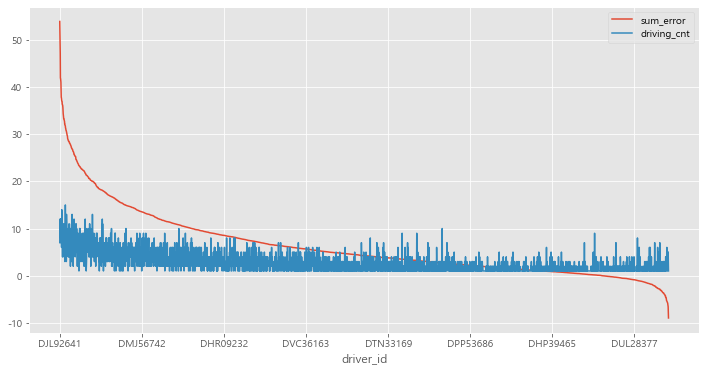

In [117]:
df_result.plot()
plt.show()

일반적인 선그래프로는 인사이트를 얻기가 어렵다 ㅜㅜ
운전횟수가 제일 많은 게 몇 번이지?

In [119]:
# 운전 횟수에 대하여 내림차순
df_result.sort_values('driving_cnt', ascending=False)

,sum_error,driving_cnt
driver_id,,
DHP35897,31.76,15
DJN80873,37.04,14
DHP29966,26.86,13
DRD89607,30.51,13
DST66086,19.99,13
...,...,...
DWZ49617,2.37,1
DHP76166,2.38,1
DHR19541,2.40,1


운전횟수를 기준으로 산점도를 그려보자.

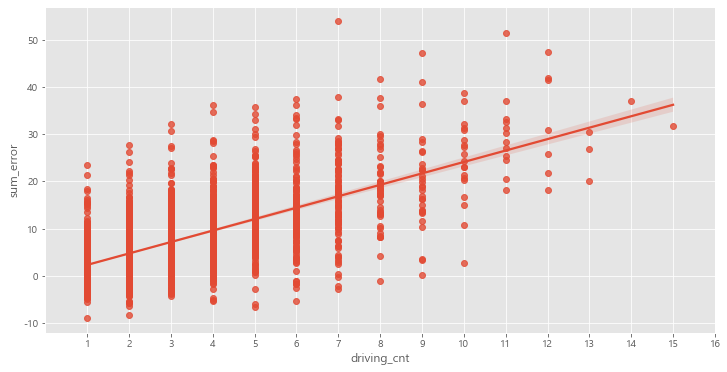

In [126]:
sns.regplot(x='driving_cnt', y='sum_error', data=df_result)
plt.xlim(0,16)
plt.xticks(list(range(1,17)))
plt.show()

### 알 수 있는 사실
- 제일 높은 점들이 확실히 운전 횟수가 많다.
- 운전 횟수가 많다는 기준이 애매하더라도 경향선을 보면 운전횟수가 많을수록 시간오차 합계가 크다는 것을 알 수 있다.